In [6]:
from digicampipe.scripts.effective_area import get_fitted
from digicampipe.io.dl1 import read_hdf5, read_event_histogram 
from digicampipe.visualization.machine_learning import LABELS, plot_3d_histo, compute_bin_centers, compute_effective_area, crab_spectrum, proton_spectrum
from digicampipe.pointing.disp import angular_distance
from digicampipe.image.hillas import compute_alpha
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os
from os.path import join
import pandas as pd
import h5py
from tqdm import tqdm_notebook as tqdm
%matplotlib qt

figsize=(10, 8)

# Convert DL1 from lstchain to digicampipe

In [2]:
version = 'v3'
directory = '/sst1m/analyzed/mpeshowerfit/lst/dl1/{}/'.format(version)
output_directory = '/home/alispach/figures/lst_montecarlo/{}/'.format(version)
data_path = 'dl1/event/telescope/parameters/LST_LSTCam'
gamma_file = os.path.join(directory, 'dl1_gamma.h5')
gamma_diffuse_file = os.path.join(directory, 'dl1_gamma-diffuse.h5')
proton_file = os.path.join(directory, 'dl1_proton.h5')
electron_file = os.path.join(directory, 'dl1_electron.h5')
image_parameters = ['y', 'x', 't_68', 'intensity', 'wol', 'r', 'phi', 'psi', 'width', 'length', 'alpha', 'area']

In [3]:
def get_rate_gamma(bins_energy, bins_impact,):
    
    e, d_e = compute_bin_centers(bins_energy)
    r, d_r = compute_bin_centers(bins_impact)

    rate = np.zeros((len(e), len(r)))
    spectrum = crab_spectrum(energy=e)

    for i in range(len(r)):
            rate[:, i] = spectrum * d_e * (d_r[i]**2 + 2 * bins_impact[i] * d_r[i]) * np.pi

    return rate


def get_rate_diffuse(bins_energy, bins_impact, bins_theta, spectrum_function):


    e, d_e = compute_bin_centers(bins_energy)
    r, d_r = compute_bin_centers(bins_impact)
    bins_omega = 2 * np.pi * (1 - np.cos(bins_theta))
    omega, d_omega = compute_bin_centers(bins_omega)

    rate = np.zeros((len(e), len(r), len(omega)))
    spectrum = spectrum_function(energy=e)

    for i in range(len(r)):
        for j in range(len(omega)):

            rate[:, i, j] = spectrum * d_e * (d_r[i]**2 + 2 * bins_impact[i] * d_r[i]) * np.pi * d_omega[j]
    rate = rate.sum(axis=-1)
    return rate

def _power_law(E, N, k):
    flux = N * (E/1) ** (-k) #  m^-2 s^-1 TeV^-1 sr^-1
    return flux


def _log_normal(E, L, E_p, w):
    term1 = L / (E * w * np.sqrt(2 * np.pi))
    term2 = np.exp(-np.log(E / E_p) ** 2 / (2 * w ** 2)) # 'm^-2 s^-1 sr^-1
    return term1 * term2


def electron_spectrum(energy, N=6.85e-5, k=3.21, L=3.19e-3, E_p=0.107, w=0.776):
    flux = _power_law(energy, N, k)
    flux += _log_normal(energy, L, E_p, w)
    return flux

def get_rate_electron(bins_energy, bins_impact, bins_theta):
    
    return get_rate_diffuse(bins_energy, bins_impact, bins_theta, electron_spectrum)

def get_rate_proton(bins_energy, bins_impact, bins_theta):

    return get_rate_diffuse(bins_energy, bins_impact, bins_theta, proton_spectrum)

/home/alispach/.conda/envs/digicampipe/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


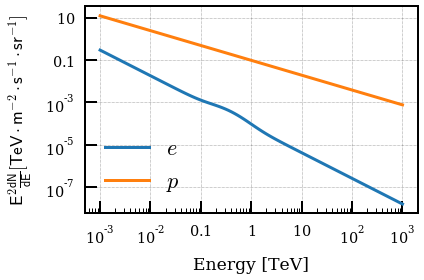

In [4]:
e = np.logspace(-3, 3, num=100)
fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(e, e**2*electron_spectrum(e), label='$e$')
axes.plot(e, e**2*proton_spectrum(e), label='$p$')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Energy [TeV]')
axes.set_ylabel(r'$\mathsf{E^{2} \frac{dN}{dE} [TeV \cdot m^{-2} \cdot s^{-1} \cdot sr^{-1} ]}$')
axes.legend(loc='best')

In [14]:
e = np.logspace(-2, 3, num=5*5+1)
e_w = np.diff(e)
e_center = e[:-1] + 0.5 * e_w


n_e = electron_spectrum(e_center) * e_w
n_p = proton_spectrum(e_center) * e_w
fig = plt.figure()
axes = fig.add_subplot(111)
axes.errorbar(e_center, n_p/n_e, xerr=e_w*0.5, linestyle='None', marker='o', label='$n_p$/$n_e$')
axes.set_xlabel('Energy [TeV]')
axes.set_ylabel(r'Ratio []')
axes.legend(loc='best')
axes.set_xscale('log')
axes.set_yscale('log')


In [6]:
!mkdir -p $output_directory

In [18]:
def add_parameters(df):
    
    # Rename columns
    mapper = {'wl': 'wol', 'leakage2_intensity': 'leakage', 'disp_dx':'disp_x', 'disp_dy':'disp_y',
          'disp_norm': 'disp_r', 'disp_angle':'disp_theta', 'time_gradient': 'slope',
         'mc_core_x': 'core_x', 'mc_core_y': 'core_y', 'mc_alt': 'alt', 'mc_alt_tel': 'tel_alt',
         'mc_az': 'az', 'mc_az_tel': 'tel_az', 'src_x': 'source_x', 'src_y': 'source_y',
             'mc_energy': 'true_energy', 'log_mc_energy': 'log_energy', 
              'skewness': 'skewness_l', 'kurtosis': 'kurtosis_w'} 
    df.rename(columns=mapper, inplace=True)
    
    # Convert to mm
    df['r'] *= 1E3
    df['x'] *= 1E3
    df['y'] *= 1E3
    df['width'] *= 1E3
    df['length'] *= 1E3
    df['disp_x'] *=1E3
    df['disp_y'] *= 1E3
    df['disp_r'] *= 1E3
    df['source_x'] *= 1E3
    df['source_y'] *= 1E3
    df['slope'] *= 1E-3
    
    # Add parameters
    df['v'] = 1 / df['slope']
    df['t_68'] = df['length'] / df['v']
    df['alpha'] = compute_alpha(phi=df['phi'], psi=df['psi'])
    df['area'] = np.pi * df['width'] * df['length']
    df['delta'] = angular_distance(df['alt'], df['az'], df['tel_alt'], df['tel_az'])
    df['impact'] = np.sqrt(df['core_x'] ** 2 + df['core_y'] ** 2)
    df['density'] = df['intensity'] / df['area']
    df['density_l'] = df['intensity'] / df['length']
    df['density_w'] = df['intensity'] / df['width']
    df['log_lh'] = np.zeros(len(df))

    
   
    return df


def read(file, particle='proton'):
    
    with h5py.File(file, 'r') as f:
        
        spectral_index = f['simulation/run_config']['spectral_index'][0]
        e_min = np.array(f['simulation/run_config']['energy_range_min']).min()
        e_max = np.array(f['simulation/run_config']['energy_range_max']).max()
        count = f['simulation/thrown_event_distribution']['histogram']
        theta_min = np.radians(f['simulation/run_config']['min_viewcone_radius']).min()
        theta_max = np.radians(f['simulation/run_config']['max_viewcone_radius']).max()

        count = count.sum(axis=0)
        bins_impact = f['simulation/thrown_event_distribution']['bins_core_dist'][0]
        bins_energy = f['simulation/thrown_event_distribution']['bins_energy'][0]
        bins_theta = np.linspace(theta_min, theta_max, num=150)

        bins_energy_mid = np.diff(bins_energy) * 0.5 + bins_energy[:-1]
        bins_impact_mid = np.diff(bins_impact) * 0.5 + bins_impact[:-1]
        bins_theta_mid = np.diff(bins_theta) * 0.5 + bins_theta[:-1]

        bins = [bins_energy, bins_impact, bins_theta]
        bins_centers = [bins_energy_mid, bins_impact_mid, bins_theta_mid]

        if particle == 'proton':

            rate = get_rate_proton(bins_energy=bins_energy, bins_impact=bins_impact, bins_theta=bins_theta)

        elif particle == 'gamma':

            rate = get_rate_gamma(bins_energy, bins_impact=bins_impact)
            
        elif particle == 'electron':
        
            rate = get_rate_electron(bins_energy=bins_energy, bins_impact=bins_impact, bins_theta=bins_theta)

        weights = rate / count
        mask = np.isfinite(weights)
        weights[~mask] = 0.
        
    df = pd.read_hdf(file, key='dl1/event/telescope/parameters/LST_LSTCam')

    df = add_parameters(df)
    df['weights'] = np.zeros(len(df))
    index = np.arange(len(df))
    for i in tqdm(range(len(bins_energy)-1)):
        for j in range(len(bins_impact)-1):

            mask = (df['true_energy'] >= bins_energy[i]) & (df['true_energy'] < bins_energy[i+1]) & (df['impact'] >= bins_impact[j]) & (df['impact'] < bins_impact[j+1])
            df['weights'].iloc[index[mask]] = weights[i, j]

    print ('Rate : {} [Hz]'.format(df['weights'].sum()))
    
    if particle == 'proton':
    
        df['particle'] = np.ones(len(df)) * 101
    
    elif particle == 'gamma':
        df['particle'] = np.ones(len(df))
    
    
    output_file = os.path.splitext(file)[0] + '_converted.h5'
    df.to_hdf(output_file, key='data', mode='w')
    
    return count, bins, df
        


In [19]:
electron_file

'/sst1m/analyzed/mpeshowerfit/lst/dl1/v3/dl1_electron.h5'

In [20]:
# proton_count, proton_bins, df_proton = read(proton_file, particle='proton')
# gamma_count, gamma_bins, df_gamma = read(gamma_file, particle='gamma')
# gamma_diffuse_count, gamma_diffuse_bins, df_gamma_diffuse = read(gamma_diffuse_file, particle='gamma')
electron_count, electron_bins, df_electron = read(electron_file, particle='electron')

/home/alispach/.conda/envs/digicampipe/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/home/alispach/Documents/PhD/ctasoft/digicampipe/digicampipe/image/hillas.py:30: RuntimeWarning: invalid value encountered in minimum
  alpha = np.minimum(np.pi - alpha, alpha)  # put alpha in [0, np.pi/2]


/home/alispach/.conda/envs/digicampipe/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



Rate : 670.8312142517996 [Hz]


In [9]:
def add_trigger_info(file, bins, count):
    
    with h5py.File(file, 'r+') as h:
        
        group = h.create_group("trigger")
        group.create_dataset('histo', data=count)
        group.create_dataset('bins_energy', data=bins[0])
        group.create_dataset('bins_impact', data=bins[1])
        group.create_dataset('bins_theta', data=bins[2])
add_trigger_info(join(directory, 'dl1_proton_converted.h5'), bins=proton_bins, count=proton_count)
add_trigger_info(join(directory, 'dl1_gamma_converted.h5'), bins=gamma_bins, count=gamma_count)
add_trigger_info(join(directory, 'dl1_gamma-diffuse_converted.h5'), bins=gamma_diffuse_bins, count=gamma_diffuse_count)
add_trigger_info(join(directory, 'dl1_electron_converted.h5'), bins=electron_bins, count=electron_count)

NameError: name 'electron_bins' is not defined

# Plot 

In [16]:
plt.figure()
plt.hist(df_proton['log_energy'], bins=100, weights=df_proton['weights'], label='$p$', histtype='step')
plt.hist(df_gamma['log_energy'], bins=100, weights=df_gamma['weights'], label='$\gamma$', histtype='step')
plt.xlabel(r'$\log_{10} \frac{E}{{\rm [TeV]}}$')
plt.ylabel(r'Rate [Hz]')
plt.yscale('log')
plt.legend(loc='best')

plt.figure()
plt.hist(df_proton['log_intensity'], bins=100, weights=df_proton['weights'], label='$p$', histtype='step')
plt.hist(df_gamma['log_intensity'], bins=100, weights=df_gamma['weights'], label='$\gamma$', histtype='step')
plt.xlabel(r'$\log_{10}\frac{\mu}{{\rm [p.e.]}}$')
plt.ylabel(r'Rate [Hz]')
plt.yscale('log')
plt.legend(loc='best')

plt.figure()
plt.hist(df_proton['width'], bins=100, weights=df_proton['weights'], label='$p$', histtype='step')
plt.hist(df_gamma['width'], bins=100, weights=df_gamma['weights'], label='$\gamma$', histtype='step')
plt.xlabel(r'$\sigma_w$ [mm]')
plt.ylabel(r'Rate [Hz]')
plt.yscale('log')
plt.legend(loc='best')

print(df_proton['weights'].sum(), df_gamma['weights'].sum())

/home/alispach/.conda/envs/digicampipe/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/alispach/.conda/envs/digicampipe/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


32544.888183175488 21.970498654697334


,concentration_cog,concentration_core,concentration_pixel,event_id,gps_time,intensity,intercept,kurtosis,leakage1_intensity,leakage1_pixel,...,disp_sign,source_x,source_y,v,t_68,alpha,area,delta,impact,weights
0,0.245890,0.465082,0.142237,2800,1.555916e+09,334.129159,0.240739,2.636400,0.000000,0.000000,...,-1.0,0.344964,-1.177339,2.492142,3.877641e+02,1.368691,4.376097e+04,0.043815,405.886156,0.077270
1,0.131663,0.384425,0.178046,2801,1.555916e+09,555.111715,0.282358,2.100439,0.000000,0.000000,...,1.0,0.344964,-1.177339,0.002494,6.874949e-01,0.614386,6.501567e+04,0.043815,173.493435,0.077186
2,0.628424,0.462059,0.252871,2801,1.555916e+09,116.810964,-1.403899,3.068369,0.000000,0.000000,...,-1.0,0.344964,-1.177339,0.010306,7.958114e-01,0.142901,1.152555e+04,0.043815,173.493435,0.077186
3,0.459688,0.294754,0.246294,2801,1.555916e+09,106.321676,-1.357331,3.035520,0.000000,0.000000,...,1.0,0.344964,-1.177339,0.000210,1.991748e-02,1.187366,1.720991e+04,0.043815,173.493435,0.077186
4,0.432613,0.388228,0.215376,2801,1.555916e+09,154.647214,-1.079558,2.376705,0.000000,0.000000,...,1.0,0.344964,-1.177339,0.000564,6.095597e-02,0.258981,1.665921e+04,0.043815,173.493435,0.077186
5,0.201069,0.227056,0.169441,7604,1.555916e+09,103.385606,0.481152,1.458643,0.000000,0.000000,...,-1.0,-0.438342,-1.722906,0.000048,1.354802e-02,0.670164,6.234651e+04,0.063490,359.708930,0.023044
6,0.225576,0.458248,0.134654,7604,1.555916e+09,95.076751,-0.439202,2.489118,0.423475,0.002695,...,-1.0,-0.438342,-1.722906,0.000123,2.595292e-02,0.987610,6.615380e+04,0.063490,359.708930,0.023044
7,0.136760,0.333596,0.083484,7604,1.555916e+09,344.963247,0.175310,2.356906,0.096288,0.002156,...,-1.0,-0.438342,-1.722906,0.000110,6.188633e-02,0.001574,1.646903e+05,0.063490,359.708930,0.023044
8,0.419470,0.213301,0.239063,7604,1.555916e+09,72.755015,-1.850178,2.285043,0.000000,0.000000,...,-1.0,-0.438342,-1.722906,0.000116,1.320561e-02,0.037360,1.714035e+04,0.063490,359.708930,0.023044
9,0.392311,0.392311,0.186643,8802,1.555916e+09,82.776263,-1.300232,1.822359,0.000000,0.000000,...,1.0,-0.119035,3.449495,0.000578,6.506764e-02,1.025496,2.289286e+04,0.123269,823.401855,0.065934


In [ ]:
X, Y = np.meshgrid(bins_centers[0], bins_centers[1])

fig = plt.figure()
axes = fig.add_subplot(111)
im = axes.pcolor(X, Y, count, norm=LogNorm())
axes.set_xlabel('Energy [TeV]')
axes.set_ylabel('Impact distance [m]')
axes.set_xscale('log')
fig.colorbar(im, label='count []', ax=axes)

fig = plt.figure()
axes = fig.add_subplot(111)
axes.step(bins_centers[0], count.sum(axis=0) / np.diff(bins[0]), label='Simulated particles')
e = bins_centers[0]

mask = count.sum(axis=0) > 0
e = e[mask]
e_min = e.min()
e_max = e.max()
x = np.linspace(e_min, e_max, num=100)

def dnde(e, alpha, ntot, emin, emax):
    
    gamma = 1-alpha
    factor = gamma / (emax**gamma - emin**gamma)
    
    if alpha == 1:
        
        factor = 1 / (np.log(emax) - np.log(emin))
    
    y = ntot * factor * e**-alpha
    return y

y = dnde(x, 2, count.sum(), e_min, e_max,)

def compute_weights(e, alpha, alpha_prime, emin, emin_prime, emax, emax_prime):
    

    def compute_factor(alpha, emin, emax):
        gamma = 1 - alpha
        factor = gamma / (emax**gamma - emin**gamma)
    
        if alpha == 1:
        
            factor = 1 / (np.log(emax) - np.log(emin))
        return factor
        
    factor = compute_factor(alpha, emin, emax)
    factor_prime = compute_factor(alpha_prime, emin_prime, emax_prime)
    weights = factor_prime / factor * e**(-alpha_prime + alpha)
    
    return weights
beta = count.sum() * (1-2) / (e_max**-1 - e_min**-1)
beta_prime = 0.096
weights = compute_weights(x, 2, 2.7, e_min, e_min, e_max, e_max)
print(weights)
axes.plot(x, y, label='$\sim E^{-2}$')
axes.plot(x, y*weights, label='weighted sim')
print((weights * y).sum())
print(y.sum())
axes.set_yscale('log')
axes.set_xscale('log')
axes.set_xlabel('Energy [TeV]')
axes.set_ylabel('dN/dE [TeV$^{-1}$]')
axes.legend(loc='best')

de = np.diff(bins[0])
fig = plt.figure()
axes = fig.add_subplot(111)
weights_rate = beta_prime / beta * bins_centers[0] **(-2.7 + 2)
y = count.sum(axis=0) / (de) *weights_rate
axes.plot(bins_centers[0], y, label='weighted sim')
print(np.trapz(y, bins_centers[0]))
axes.set_yscale('log')
axes.set_xscale('log')
axes.set_xlabel('Energy [TeV]')
axes.set_ylabel('dN/dEdSdtdOmega [TeV$^{-1}$]')
axes.legend(loc='best')

In [ ]:
df_gamma_test = pd.read_hdf(gamma_test_file, key=data_path)
df_gamma_train = pd.read_hdf(gamma_train_file, key=data_path)
df_proton_test = pd.read_hdf(proton_test_file, key=data_path)
df_proton_train = pd.read_hdf(proton_train_file, key=data_path)

In [17]:
labels = ['On-axis $\gamma$', 'Diffuse $\gamma$', 'Diffuse $p$ (Test)', 'Diffuse $p$ (Train)']
names = ['gamma_test', 'gamma_train', 'proton_test', 'proton_train']


dfs = [df_gamma_test, df_gamma_train, df_proton_test, df_proton_train]




NameError: name 'df_gamma_test' is not defined

In [ ]:
print(dfs[0].columns)

# Quality cut probability

In [ ]:
options = {'histtype': 'step', 'lw':3, 'density': True}
plt.figure(figsize=figsize)
bins = np.logspace(0, 6, num=100)
for i, df in enumerate(dfs):
    plt.hist(df['intensity'], bins=bins, label=labels[i], **options)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Size [p.e.]')
plt.ylabel('Normalized counts []')
plt.legend(loc='best')
plt.savefig(os.path.join(output_directory, 'size_distribution_triggered.pdf'))

plt.figure(figsize=figsize)
bins = np.linspace(0, 1, num=100)
for i, df in enumerate(dfs):
    plt.hist(df['wol'], bins=bins, label=labels[i], **options)
plt.yscale('log')
plt.xlabel('Width over length []')
plt.ylabel('Normalized counts []')
plt.legend(loc='best')
plt.savefig(os.path.join(output_directory, 'wol_distribution_triggered.pdf'))


plt.figure(figsize=figsize)
bins = np.linspace(0, 1, num=100)
for i, df in enumerate(dfs):
    plt.hist(df['leakage'], bins=bins, label=labels[i], **options)
plt.yscale('log')
plt.xlabel('Leakage []')
plt.ylabel('Normalized counts []')
plt.legend(loc='best')
plt.savefig(os.path.join(output_directory, 'containement_distribution_triggered.pdf'))

In [ ]:

for i, label in enumerate(labels):

    bins_x = np.linspace(0, 1, num=100)
    plt.figure(figsize=figsize)
    bins_y = np.linspace(0, 1, num=100)
    plt.title(label)
    plt.hist2d(dfs[i]['leakage'], dfs[i]['wol'], bins=[bins_x, bins_y], norm=LogNorm())
    plt.xlabel('Containment []')
    plt.ylabel('Width over length []')
    plt.colorbar(label='Counts []')
    plt.legend(loc='best')
    plt.savefig(os.path.join(output_directory, 'containement_vs_wol_distribution_triggered_{}.pdf'.format(names[i])))
    
    plt.figure(figsize=figsize)
    bins_y = np.linspace(0, 1000, num=100)
    plt.title(label)
    plt.hist2d(dfs[i]['leakage'], dfs[i]['r'], bins=[bins_x, bins_y], norm=LogNorm())
    plt.xlabel('Containment []')
    plt.ylabel('$r_{CM}$ [mm]')
    plt.colorbar(label='Counts []')
    plt.legend(loc='best')
    plt.savefig(os.path.join(output_directory, 'containement_vs_r_distribution_triggered_{}.pdf'.format(names[i])))
    
    
    plt.figure(figsize=figsize)
    plt.title(label)
    bins = np.logspace(0, 6, num=100)
    bins_y = np.linspace(0, 1, num=100)
    plt.hist2d(dfs[i]['intensity'], dfs[i]['wol'], bins=[bins, bins_y], norm=LogNorm())
    plt.xlabel('Size [p.e.]')
    plt.xscale('log')
    plt.ylabel('width over length []')
    plt.colorbar(label='Counts []')
    plt.legend(loc='best')
    plt.savefig(os.path.join(output_directory, 'intensity_vs_wol_distribution_triggered_{}.pdf'.format(names[i])))
    
    plt.figure(figsize=figsize)
    bins = np.logspace(0, 6, num=100)
    bins_y = np.linspace(0, 5, num=100)

    plt.title(label)
    plt.hist2d(dfs[i]['intensity'], dfs[i]['leakage'], bins=[bins, bins_y], norm=LogNorm())
    plt.ylabel('Containment []')
    plt.xlabel('Size [p.e.]')
    plt.xscale('log')
    plt.colorbar(label='Counts []')
    plt.legend(loc='best')
    plt.savefig(os.path.join(output_directory, 'intensity_vs_containement_distribution_triggered_{}.pdf'.format(names[i])))
 

# Image parameters distribution after quality cuts

In [ ]:
for param in image_parameters:
    
    fig = plt.figure(figsize=figsize)
    axes = fig.add_subplot(111)
    axes.set_yscale('log')
    # axes.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext(labelOnlyBase=True,))
    
    bins = 100
    h_max = 0
    h_min = np.inf
    for i, df in enumerate(dfs):
        
        x = df[param]
        label_x = LABELS[param]

        if param == 't_68':
            bins = np.linspace(0, 200, num=400)
        if param == 'phi':
            x = np.arctan2(df['y'], df['x'])
        if param == 'intensity':
            x = np.log10(x)
            label_x = r'$\log_{10} \left( \frac{\mu}{p.e.} \right)$'
                
        H = axes.hist(x, bins=bins, density=True, label=labels[i], lw=2, histtype='step')
        bins = H[1]
        h_max = max(H[0].max(), h_max)
        h_min = min(H[0].min(), h_min)
    axes.set_xlabel(label_x)
    axes.set_ylabel('Normalized counts []')
    axes.legend(loc='best')

    h_min = 10**np.floor(np.log10(h_min))
    h_max = 10**np.ceil(np.log10(h_max))
     #axes.set_ylim(h_min, h_max)
    fig.savefig(os.path.join(output_directory, 'histogram_{}_all_particle_after_quality_cuts.pdf'.format(param)))